# TUTORIAL FOR THE P3D EMULATOR (forestflow)

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from forestflow.archive import GadgetArchive3D
from forestflow.plots_v0 import plot_test_p3d
from forestflow.P3D_cINN import P3DEmulator

In [3]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/home/jchaves/Proyectos/projects/lya/ForestFlow/


## LOAD P3D ARCHIVE

In [4]:
%%time
folder_lya_data = path_program + "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)
print(len(Archive3D.training_data))

1650
CPU times: user 10.2 s, sys: 369 ms, total: 10.6 s
Wall time: 10.5 s


## TRAIN EMULATOR

Not necessary, we have pre-trained emulators

In [ ]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,  # 0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,  # 15
    Archive=Archive3D,
    )

## TEST EMULATOR

In [ ]:
sim_label = "mpg_central"
ind_book = 6
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

## LOAD TRAINED EMULATOR

To load a trained model, one needs to specify the path to the model in the argument 'model_path'.

The folder '/data/emulator_models/' contains the models trained with all the Latinhypercube simulations: 'mpg_hypercube.pt'

In [5]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,  # 0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,  # 15
    Archive=Archive3D,
    chain_samp=100_000,
    model_path="../data/emulator_models/mpg_hypercube.pt",
)

fit {'bias': -0.2265946739714242, 'beta': 1.2248241556400337, 'q1': 0.5508070368332233, 'kvav': 0.7735041489709146, 'av': 0.5316646888234277, 'bv': 1.841648720663841, 'kp': 13.45975658765607, 'q2': 0.1882466279205535}
emu {'bias': 0.22963041067123413, 'beta': 1.2103052139282227, 'q1': 0.4978519082069397, 'kvav': 0.7533842623233795, 'av': 0.5163390338420868, 'bv': 1.8042138814926147, 'kp': 13.426518440246582, 'q2': 0.23059292137622833}


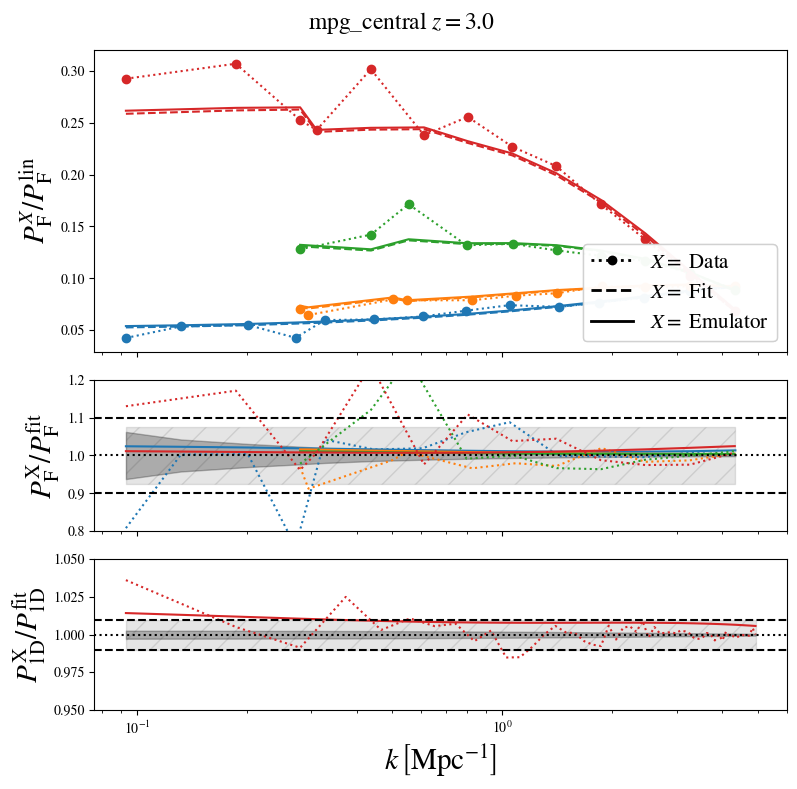

In [6]:
sim_label = "mpg_central"
ind_book = 6
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

## PREDICT P1D AND P3D

### P3D predictions

#### Test simulations

The available test simulations are:
sim_labels = ['mpg_central', 'mpg_seed', 'mpg_growth', 'mpg_neutrinos', 'mpg_curved','mpg_running', 'mpg_reio']

In [7]:
sim_label = "mpg_central"
z_test = 3

In [8]:
test_sim = central = Archive3D.get_testing_data(
    "mpg_central", force_recompute_plin=False
)
dict_sim = [d for d in test_sim if d["z"] == z_test and d["val_scaling"] == 1][0]

input_params = {}
for key in Archive3D.emu_params:
    input_params[key] = dict_sim[key]

In [9]:
input_params

{'Delta2_p': 0.3500315120932696,
 'n_p': -2.3000545227631046,
 'mF': 0.6604100706377194,
 'sigT_Mpc': 0.12817463664956008,
 'gamma': 1.512170923999183,
 'kF_Mpc': 10.6348381789184}

If we do not specify the k numbers and mu modes where the P3D is computed, it will use ones that are in the training data.
You can find them in p3d_emu.k_Mpc_masked and p3d_emu.mu_masked.



In [10]:
out = p3d_emu.predict_P3D_Mpc(
    sim_label="mpg_central",
    z=z_test, 
    emu_params=input_params
)
out.keys()

dict_keys(['coeffs_Arinyo', 'Plin', 'p3d_cov', 'p3d'])

You can also specify concrete values for the k number where the P3D is computed.

In [11]:
out = p3d_emu.predict_P3D_Mpc(
    sim_label="mpg_central", 
    z=z_test, 
    emu_params=input_params, 
    k_Mpc=p3d_emu.k_Mpc_masked,
    mu = p3d_emu.mu_masked,
)
out.keys()

dict_keys(['coeffs_Arinyo', 'Plin', 'p3d_cov', 'p3d'])

Now for a random set of k's and mu's. We can provide as input 2D arrays

In [12]:
nk = 30
nmu = 10
_k_Mpc = np.geomspace(1e-2, 4, nk)
_mu = np.linspace(0, 1, nmu)
k_Mpc = np.repeat(_k_Mpc[:, np.newaxis], nmu, axis=1)
mu = np.repeat(_mu[np.newaxis, :], nk, axis=0)

out = p3d_emu.predict_P3D_Mpc(
    sim_label="mpg_central", 
    z=z_test, 
    emu_params=input_params, 
    k_Mpc=k_Mpc,
    mu = mu,
)

#### Random cosmology

In [13]:
cosmo = {'H0': 67.0,
 'omch2': 0.12,
 'ombh2': 0.022,
 'mnu': 0.0,
 'omk': 0,
 'As': 2.2e-09,
 'ns': 0.94,
 'nrun': 0.0,
 'w': -1.0}

z_test = 3

input_params = {
    'Delta2_p': 0., # any value if you provide cosmology
     'n_p': 0., # any value if you provide cosmology
     'mF': 0.66,
     'sigT_Mpc': 0.13,
     'gamma': 1.5,
     'kF_Mpc': 10.6
}

nk = 100
nmu = 10
_k_Mpc = np.geomspace(1e-4, 100, nk)
_mu = np.linspace(0, 1, nmu)
k_Mpc = np.repeat(_k_Mpc[:, np.newaxis], nmu, axis=1)
mu = np.repeat(_mu[np.newaxis, :], nk, axis=0)

In [14]:
%%time
out = p3d_emu.predict_P3D_Mpc(
    z=z_test, 
    emu_params=input_params, 
    cosmo=cosmo,
    k_Mpc=k_Mpc,
    mu = mu,
    return_cov=False,
)
out.keys()

Delta2_p:  0.0 -> 0.3570359149627516
n_p:  0.0 -> -2.327612116402247
CPU times: user 5.95 s, sys: 493 ms, total: 6.44 s
Wall time: 642 ms


dict_keys(['coeffs_Arinyo', 'Plin', 'p3d'])

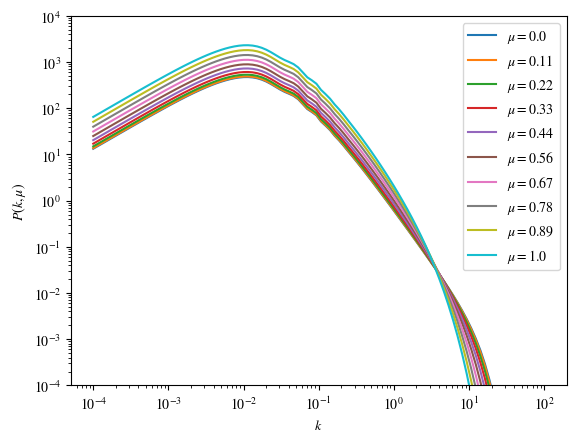

In [15]:
for ii in range(nmu):
    plt.plot(k_Mpc[:,ii], out['p3d'][:,ii], label=r'$\mu=$'+str(np.round(mu[0, ii], 2)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k, \mu)$')
plt.ylim(1e-4, 1e4)
plt.legend()

### P1D predictions

So far, this is not implemented for the predict_P1D_Mpc, which always computes the p1d default values in the simulations. This is currenly under internal discussion. You can access the kpar values of the emulated p1d as: p1d_k = dict_sim[0]['k_Mpc'][p3d_emu.k1d_mask] 

In [16]:
nkpar = 50
kpar_Mpc = np.geomspace(1e-2, 4, nkpar)

In [17]:
out = p3d_emu.predict_P3D_Mpc(
    z=z_test, 
    emu_params=input_params, 
    cosmo=cosmo,
    k_Mpc=k_Mpc,
    mu = mu,
    kpar_Mpc = kpar_Mpc,
    return_cov=False,
)
out.keys()

dict_keys(['coeffs_Arinyo', 'Plin', 'p3d', 'p1d'])

Text(0, 0.5, '$P(k_{\\rm par})$')

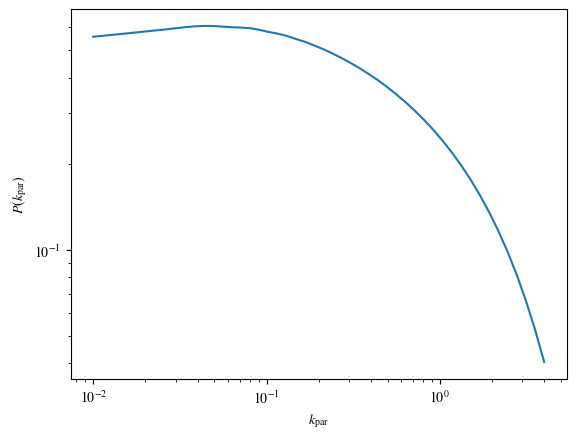

In [18]:
plt.loglog(kpar_Mpc, out['p1d'])
plt.xlabel(r'$k_{\rm par}$')
plt.ylabel(r'$P(k_{\rm par})$')